# breaking bad social network
### Liam Le

## Import dependancies

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 16.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\redli\Projects\breaking_bad\breaking_bad\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
NER = spacy.load('en_core_web_sm')
# nlp model

## Load transcripts

In [4]:
import os

In [5]:
all_seasons = [s for s in os.scandir('transcripts') if '.txt' in s.name]
all_seasons

[<DirEntry 'filename1.txt'>,
 <DirEntry 'filename2.txt'>,
 <DirEntry 'filename3.txt'>,
 <DirEntry 'filename4.txt'>,
 <DirEntry 'filename5.txt'>]

In [6]:
seasons = {}
n = 1
for season in all_seasons:
    seasons["season" + str(n)] = all_seasons[n-1]
    n +=1
    
seasons

{'season1': <DirEntry 'filename1.txt'>,
 'season2': <DirEntry 'filename2.txt'>,
 'season3': <DirEntry 'filename3.txt'>,
 'season4': <DirEntry 'filename4.txt'>,
 'season5': <DirEntry 'filename5.txt'>}

In [7]:
season1 = all_seasons[0]

season1_text = open(season1, encoding="utf8").read()
season1_doc = NER(season1_text)

In [8]:
displacy.render(season1_doc[0:100], style="ent", jupyter=True)

In [9]:
import json
import os

In [10]:
os.listdir()

['.ipynb_checkpoints',
 'breakingbad_scaper',
 'breaking_bad',
 'breaking_bad.html',
 'breaking_bad.ipynb',
 'characters_json',
 'chars.py',
 'transcripts',
 '__pycache__']

## Compare entities from transcripts and scraped characters

In [11]:
sent_entity_df = []

for sent in season1_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [28]:
sent_entity_df.head() # sentence no. || entities inside

,sentence,entities
0,"(F.D., », Transcripts, », TV, &, Movie, Transc...",[F.D. » Transcripts » TV & Movie Transcripts]
1,"(Breaking, Bad, \n, Editor, :, Tv_Gal13, \n, S...",[Desert\nWalter]
2,"(My, name, is, Walter, Hartwell, White, .)",[Walter Hartwell White]
3,"(I, live, at, 308, Negra, Arroyo, Lane, Albuqu...","[Negra, Lane Albuquerque, New Mexico, 87104]"
4,"(To, all, law, enforcement, entities, ,, this,...",[]


In [17]:
from chars import characters

def filter_entity(ent_list, characters):
    return [ent for ent in ent_list
            if ent in characters]

IndexError: list assignment index out of range

In [30]:
filter_entity(["Walter", "Geralt", "Liam", "Mike", "Heisenberg", "Matt Shin", "Gus"], characters)

[]

In [18]:
# lambda applies filter to each sentence in df
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters ))

# choose all entries without [] 
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head()

NameError: name 'filter_entity' is not defined

## Graph relationships

In [ ]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Removes self-contained relationships
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    # Maps first char(source) to relative(target) 
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})
            

In [ ]:
relationships_df = pd.DataFrame(relationships)

In [ ]:
pd.set_option('display.max_rows', None)
relationships_df.head()

In [ ]:
# Sorted
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis = 1), columns = relationships_df.columns)
relationships_df.head()

In [ ]:
# Assigning and summing a -> b relationships to create weight

relationships_df["value"] = 1
relationships_df = relationships_df.groupby(["source", "target"], sort=False, as_index=False).sum()
relationships_df

In [ ]:
# Combining name fname nname value


## Graphing visual and analysis

In [50]:
# Create graph from relationships_df

G = nx.from_pandas_edgelist(relationships_df,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())


### Networkx graph

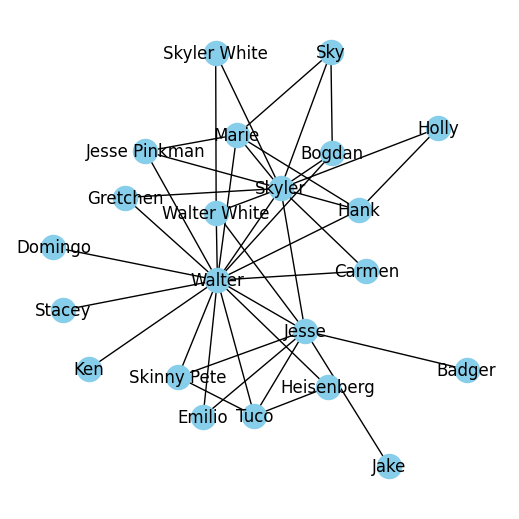

In [51]:
plt.figure(figsize=(5,5))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

### Pyvis graph

In [52]:
from pyvis.network import Network
net = Network(notebook=True, width = "1000px", height = "700px", bgcolor='222222', font_color='white')





net.from_nx(G)
net.show("breaking_bad.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
